## Step 1 - Climate Analysis and Exploration

In [8]:
# Import Dependencies 
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [9]:
import numpy as np
import pandas as pd

In [10]:
import datetime as dt

#### Reflect Tables into SQLAlchemy ORM

In [11]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [12]:
# Create a new engine instance
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [13]:
# Reflect an existing database into a new model
base = automap_base()

# Reflect the tables
base.prepare(engine, reflect=True)

In [14]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [15]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)

### Precipitation Analysis

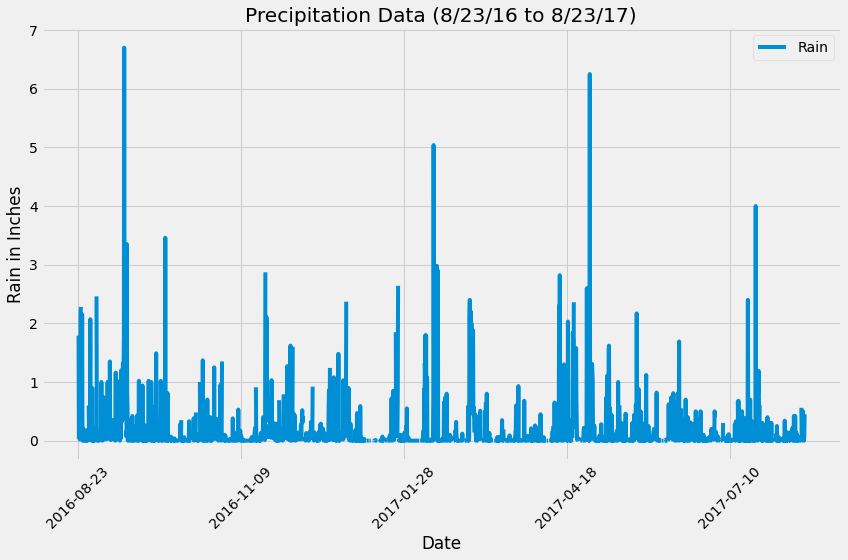

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# get the last date entry in the data table
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

# get the last 12 months of data, last date - 365
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query = session.query(measurement.date, measurement.prcp).filter(measurement.date >= prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(query)

# Sort the dataframe by date
rain_df = rain_df.sort_values(by='date',ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot('date', 'prcp', figsize=(12,8))
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Data (8/23/16 to 8/23/17)")
plt.legend(["Rain"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Figures/Precipitation.png")
plt.show()

In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
rain_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [19]:
# Design a query to show how many stations are available in this dataset?
num_station = session.query(station.id).count()
print(f'The total number of stations in this dataset is {num_station}.')

The total number of stations in this dataset is 9.


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station). \
                order_by(func.count(measurement.station).desc()).all()

station_count = {station: count for station, count in station_count}

print('Stations and Counts:')
print('--------------------')
for station,count in station_count.items():
    print(station,count)
print('====================')

Stations and Counts:
--------------------
USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_station = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').all()
active_station

[(54.0, 85.0, 71.66378066378067)]

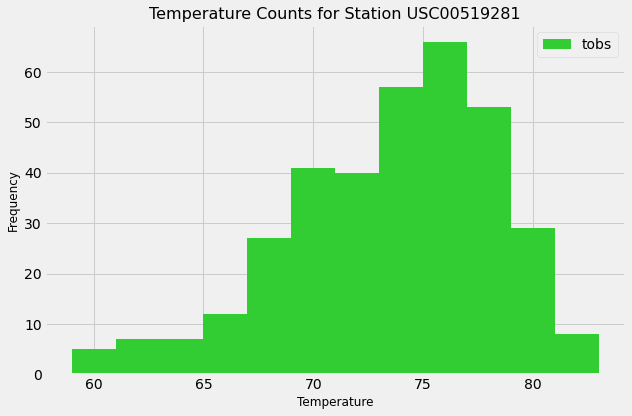

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_data = session.query(measurement.tobs, measurement.date).\
    filter(measurement.station == 'USC00519281', measurement.date >= prev_year).all()

station_data = pd.DataFrame(station_data, columns=['tobs', 'date'])

#Plot the results as a histogram with bins=12
plt.figure(figsize=(9,6))
plt.hist(station_data['tobs'].values, bins=12, color='limegreen')
plt.ylabel('Frequency',size=12)
plt.xlabel('Temperature',size=12)
plt.legend(['tobs'])
plt.title(f'Temperature Counts for Station USC00519281',size=16)
plt.tight_layout()
plt.savefig('Figures/tobsCountHistogram.png')
plt.show()

### Temperature Analysis 

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_dates = "2017-01-20 to 2017-01-27"
prev_year = "2016-01-20 - \n 2016-01-27"

prev_year_start = dt.date(2017, 1, 20) - dt.timedelta(days=365)
prev_year_end = dt.date(2017, 1, 27) - dt.timedelta(days=365)

temps = calc_temps(prev_year_start, prev_year_end)
temp_min, temp_avg, temp_max = temps[0]

print(f" Min Temp : {temp_min}F")
print(f" Avg Temp : {temp_avg}F")
print(f" Max Temp : {temp_max}F")

 Min Temp : 64.0F
 Avg Temp : 70.12F
 Max Temp : 78.0F


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = temp_max - temp_min
xpos = 1

plt.figure(figsize=(4, 8))
plt.bar(xpos, temp_avg, yerr=error, alpha=0.75, color="coral")
plt.title(f"Trip Avg Temp for Dates\n {trip_dates}")
plt.xlabel(f"{prev_year}")
plt.ylabel("Temp (F)")
plt.xticks([])
plt.yticks(np.arange(0, 120, 20))
plt.tight_layout()
plt.xlim(0.45, 1.55)
plt.ylim(0, 105)
plt.savefig("Figures/Aver.png")

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
